In [3]:
import os
import gpxpy
import requests
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import plotnine as p9
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [4]:
# Matplotlib settings

plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['svg.fonttype'] = 'none'
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300

# Plotnine settings (for figures)

p9.options.set_option('base_family', 'Georgia')

p9.theme_set(
    p9.theme_bw()
    + p9.theme(panel_grid=p9.element_blank(),
               legend_background=p9.element_blank(),
               panel_grid_major=p9.element_line(size=.5, linetype='dashed',
                                                alpha=.15, color='black'),
               plot_title=p9.element_text(ha='center'),
               dpi=300
    )
)

In [5]:
dfs = []
for file in glob('../data/flight_gps/*.gpx'):
    if 'Track' in file:
        flight = gpxpy.parse(open(file))
        points = []
        for segment in flight.tracks[0].segments:
            for p in segment.points:
                points.append({
                    'time': p.time,
                    'latitude': p.latitude,
                    'longitude': p.longitude,
                    'elevation': p.elevation,
                })
        dfs.append(pd.DataFrame.from_records(points).assign(flight=file))
dfs = (pd.concat(dfs)
      .assign(date=lambda dd: dd.time.dt.date)
      .groupby('date', as_index=False)
      .apply(lambda dd: dd.assign(timedelta=dd.time - dd.time.min()))
)

In [10]:
dfs.groupby('date')

date               
2014-02-22  0  0           NaN
               1           NaN
               2           NaN
               3           NaN
               4           NaN
                        ...   
2014-04-07  8  2051    818.894
               2052        NaN
               2053        NaN
               2054        NaN
               2055        NaN
Name: elevation, Length: 16483, dtype: float64

In [19]:
2150 * 1.03

2214.5

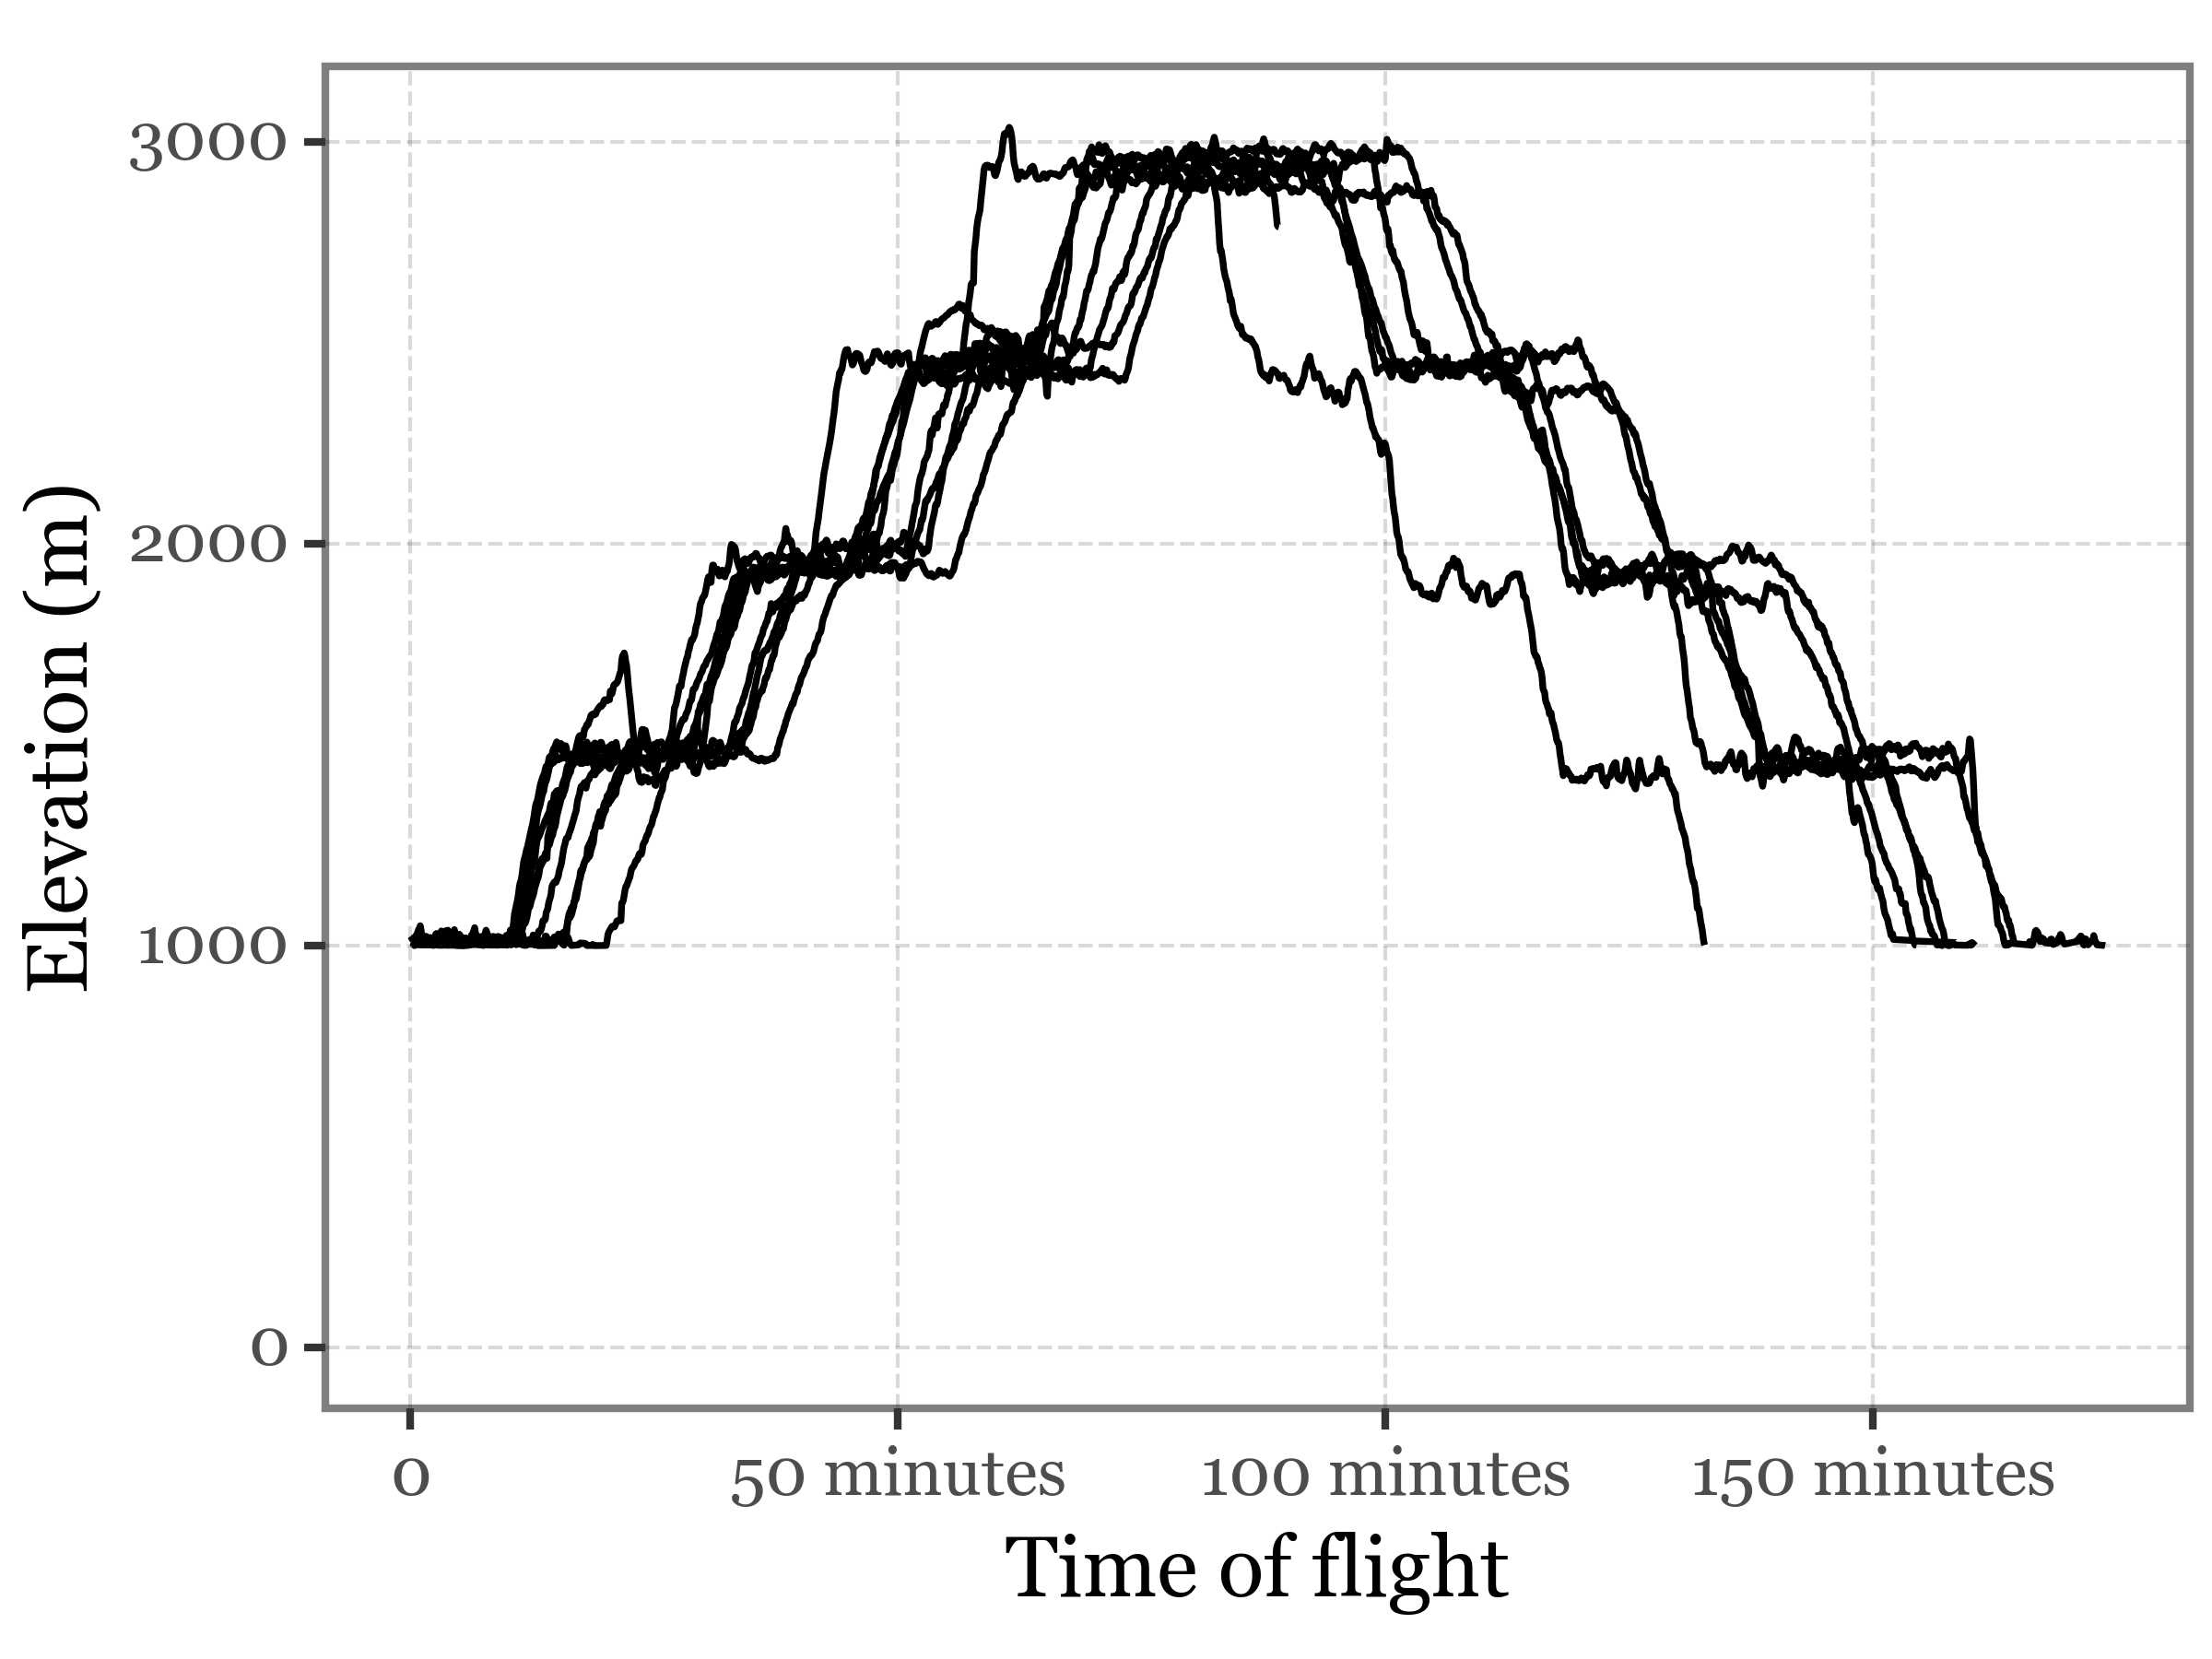

<Figure Size: (1200 x 900)>

In [21]:
(dfs
 .groupby('date')
 .apply(lambda dd: dd.assign(elevation= dd.elevation.rolling(1, center=True).mean()))
 .query('elevation >= 1000')
 .pipe(lambda dd: p9.ggplot(dd) 
    + p9.aes('timedelta', 'elevation') 
    + p9.geom_line(p9.aes(group='flight'))
    + p9.theme(figure_size=(4, 3))
    + p9.scale_y_continuous(limits=(0, None))
    + p9.labs(x='Time of flight', y='Elevation (m)')
    )

)

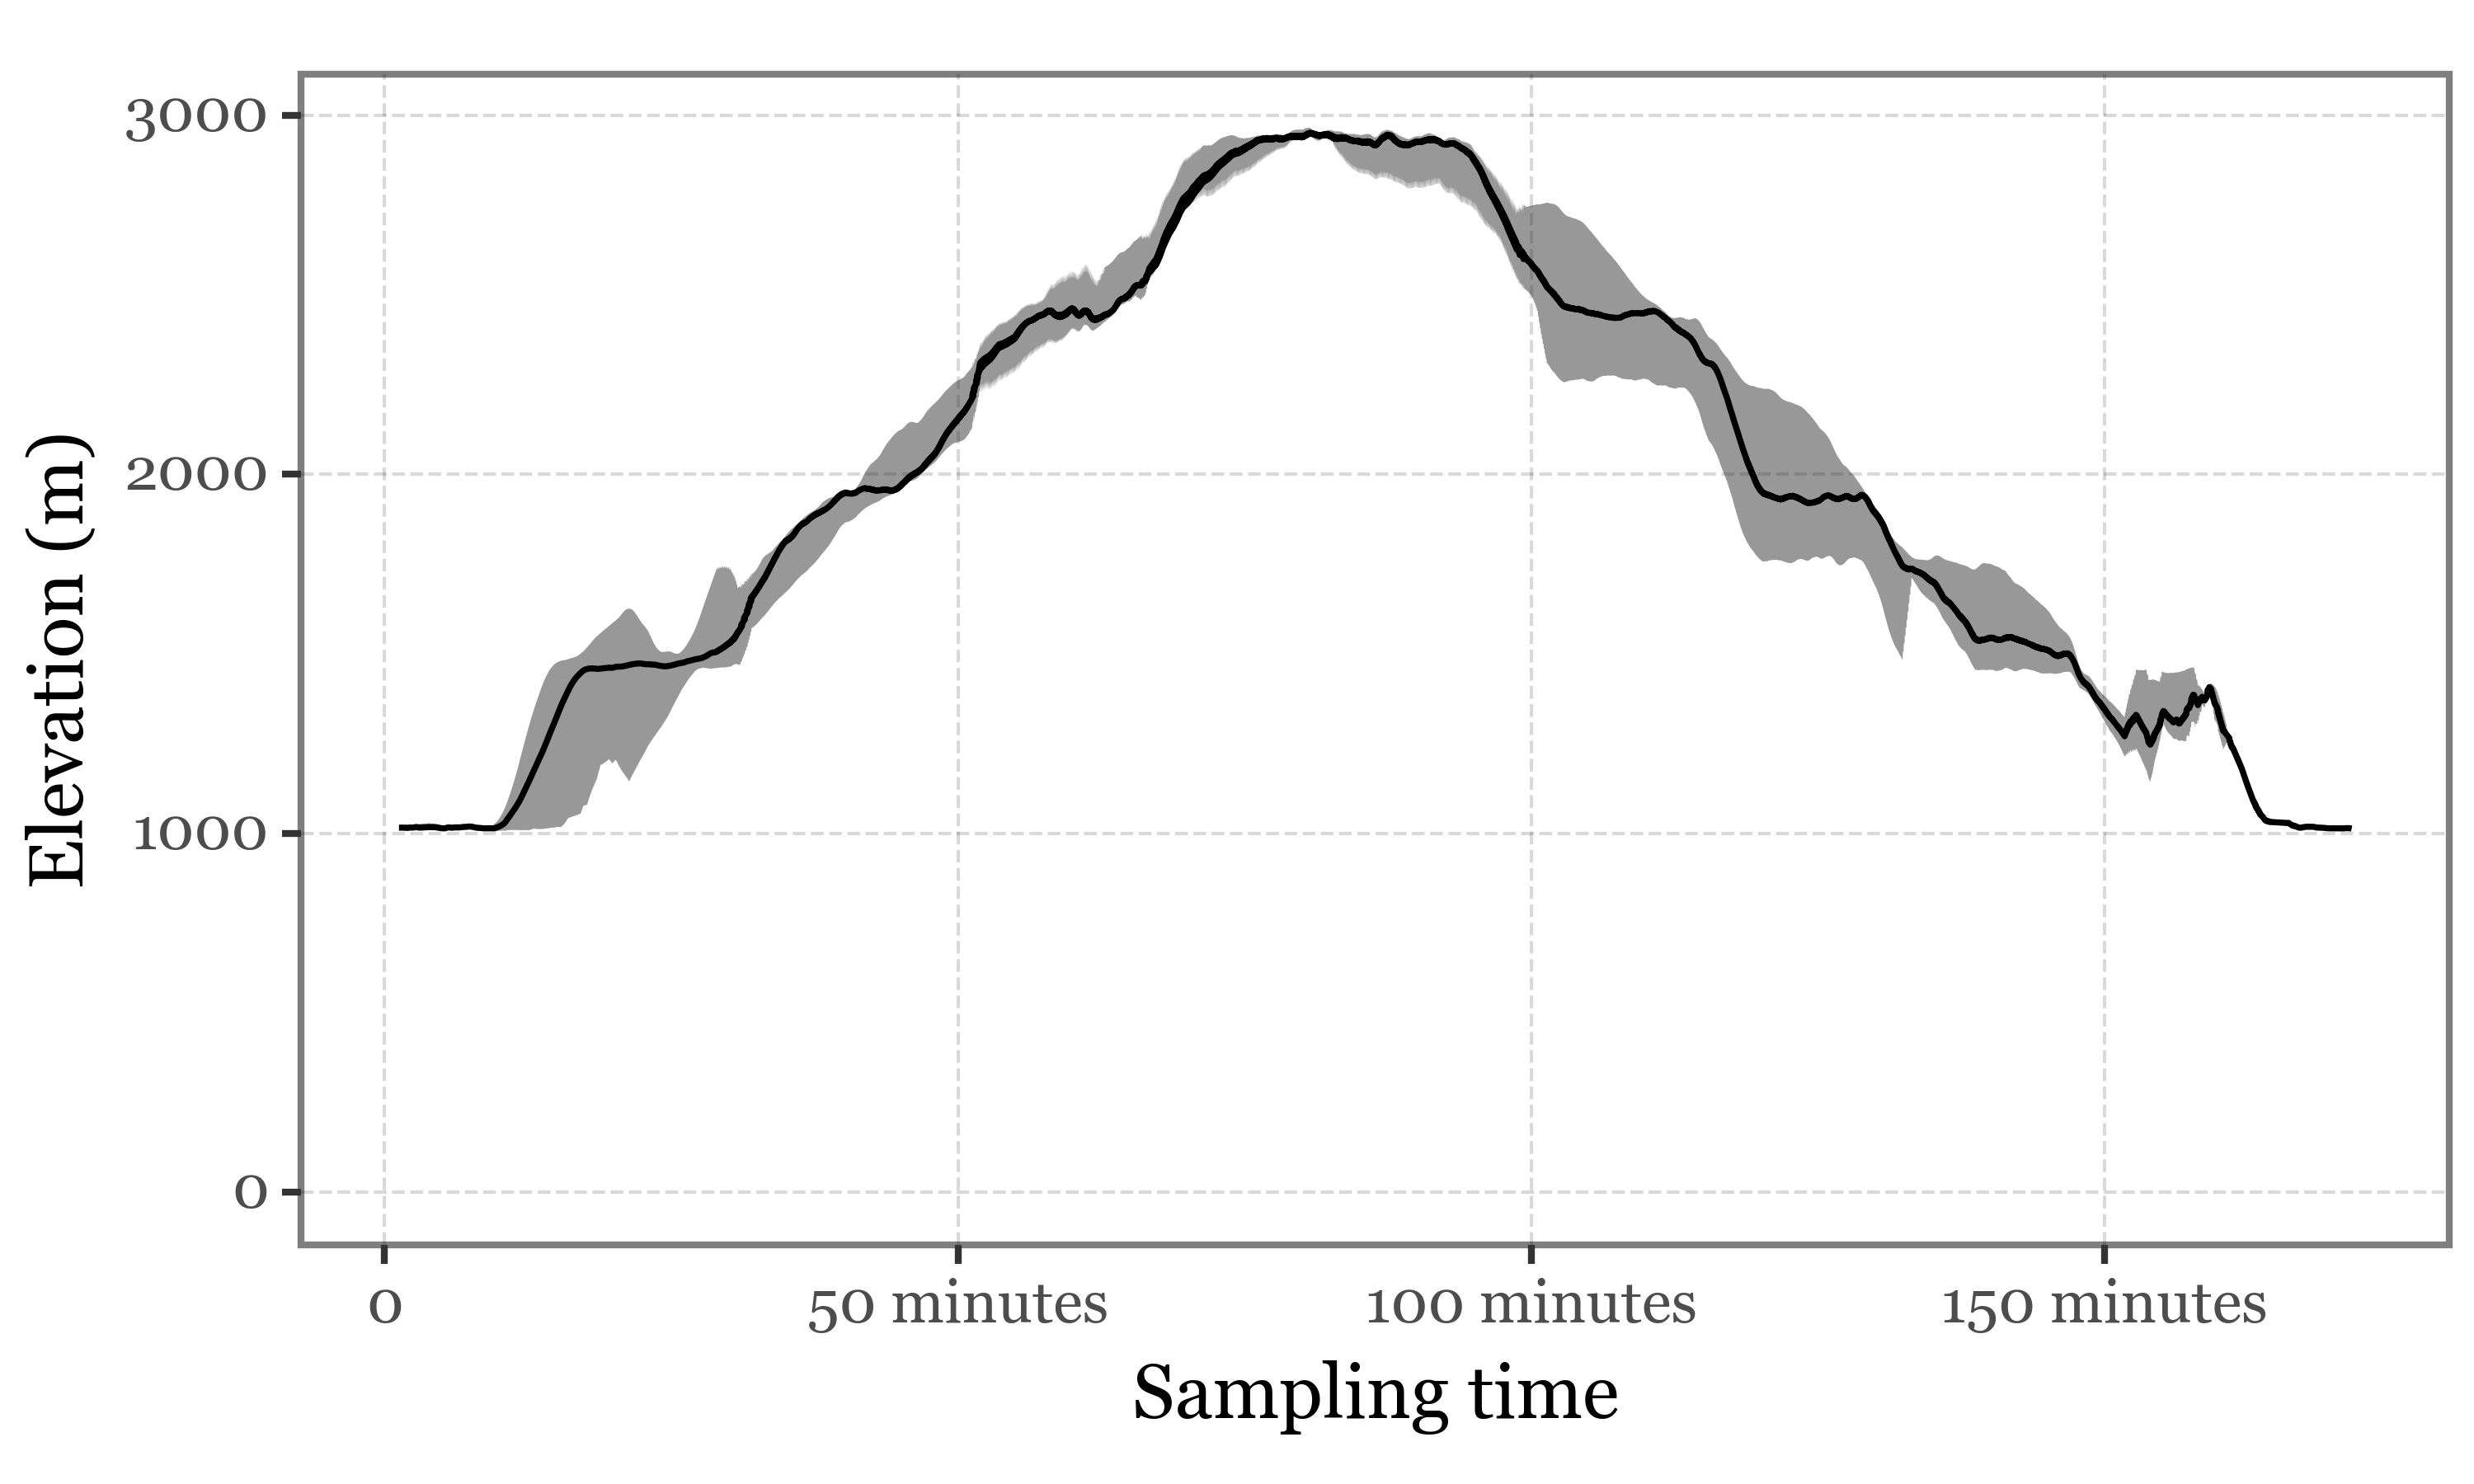

<Figure Size: (1500 x 900)>

In [44]:
(dfs
 .query('elevation >= 1000')
 .groupby(['timedelta'])
 .agg(
     median=('elevation', 'median'),
     q025=('elevation', lambda x: x.quantile(.025)),
     q975=('elevation', lambda x: x.quantile(.975))
 )
 .apply(lambda x: x.rolling(30, center=True).mean())
 .dropna()
 .reset_index()
  .pipe(lambda dd: p9.ggplot(dd) 
    + p9.aes('timedelta', 'median')
    + p9.geom_ribbon(p9.aes(ymin='q025', ymax='q975'), alpha=.5)
    + p9.geom_line()
    + p9.theme(figure_size=(5, 3))
    + p9.scale_y_continuous(limits=(0, None))
    + p9.labs(x='Sampling time', y='Elevation (m)')
    )

)

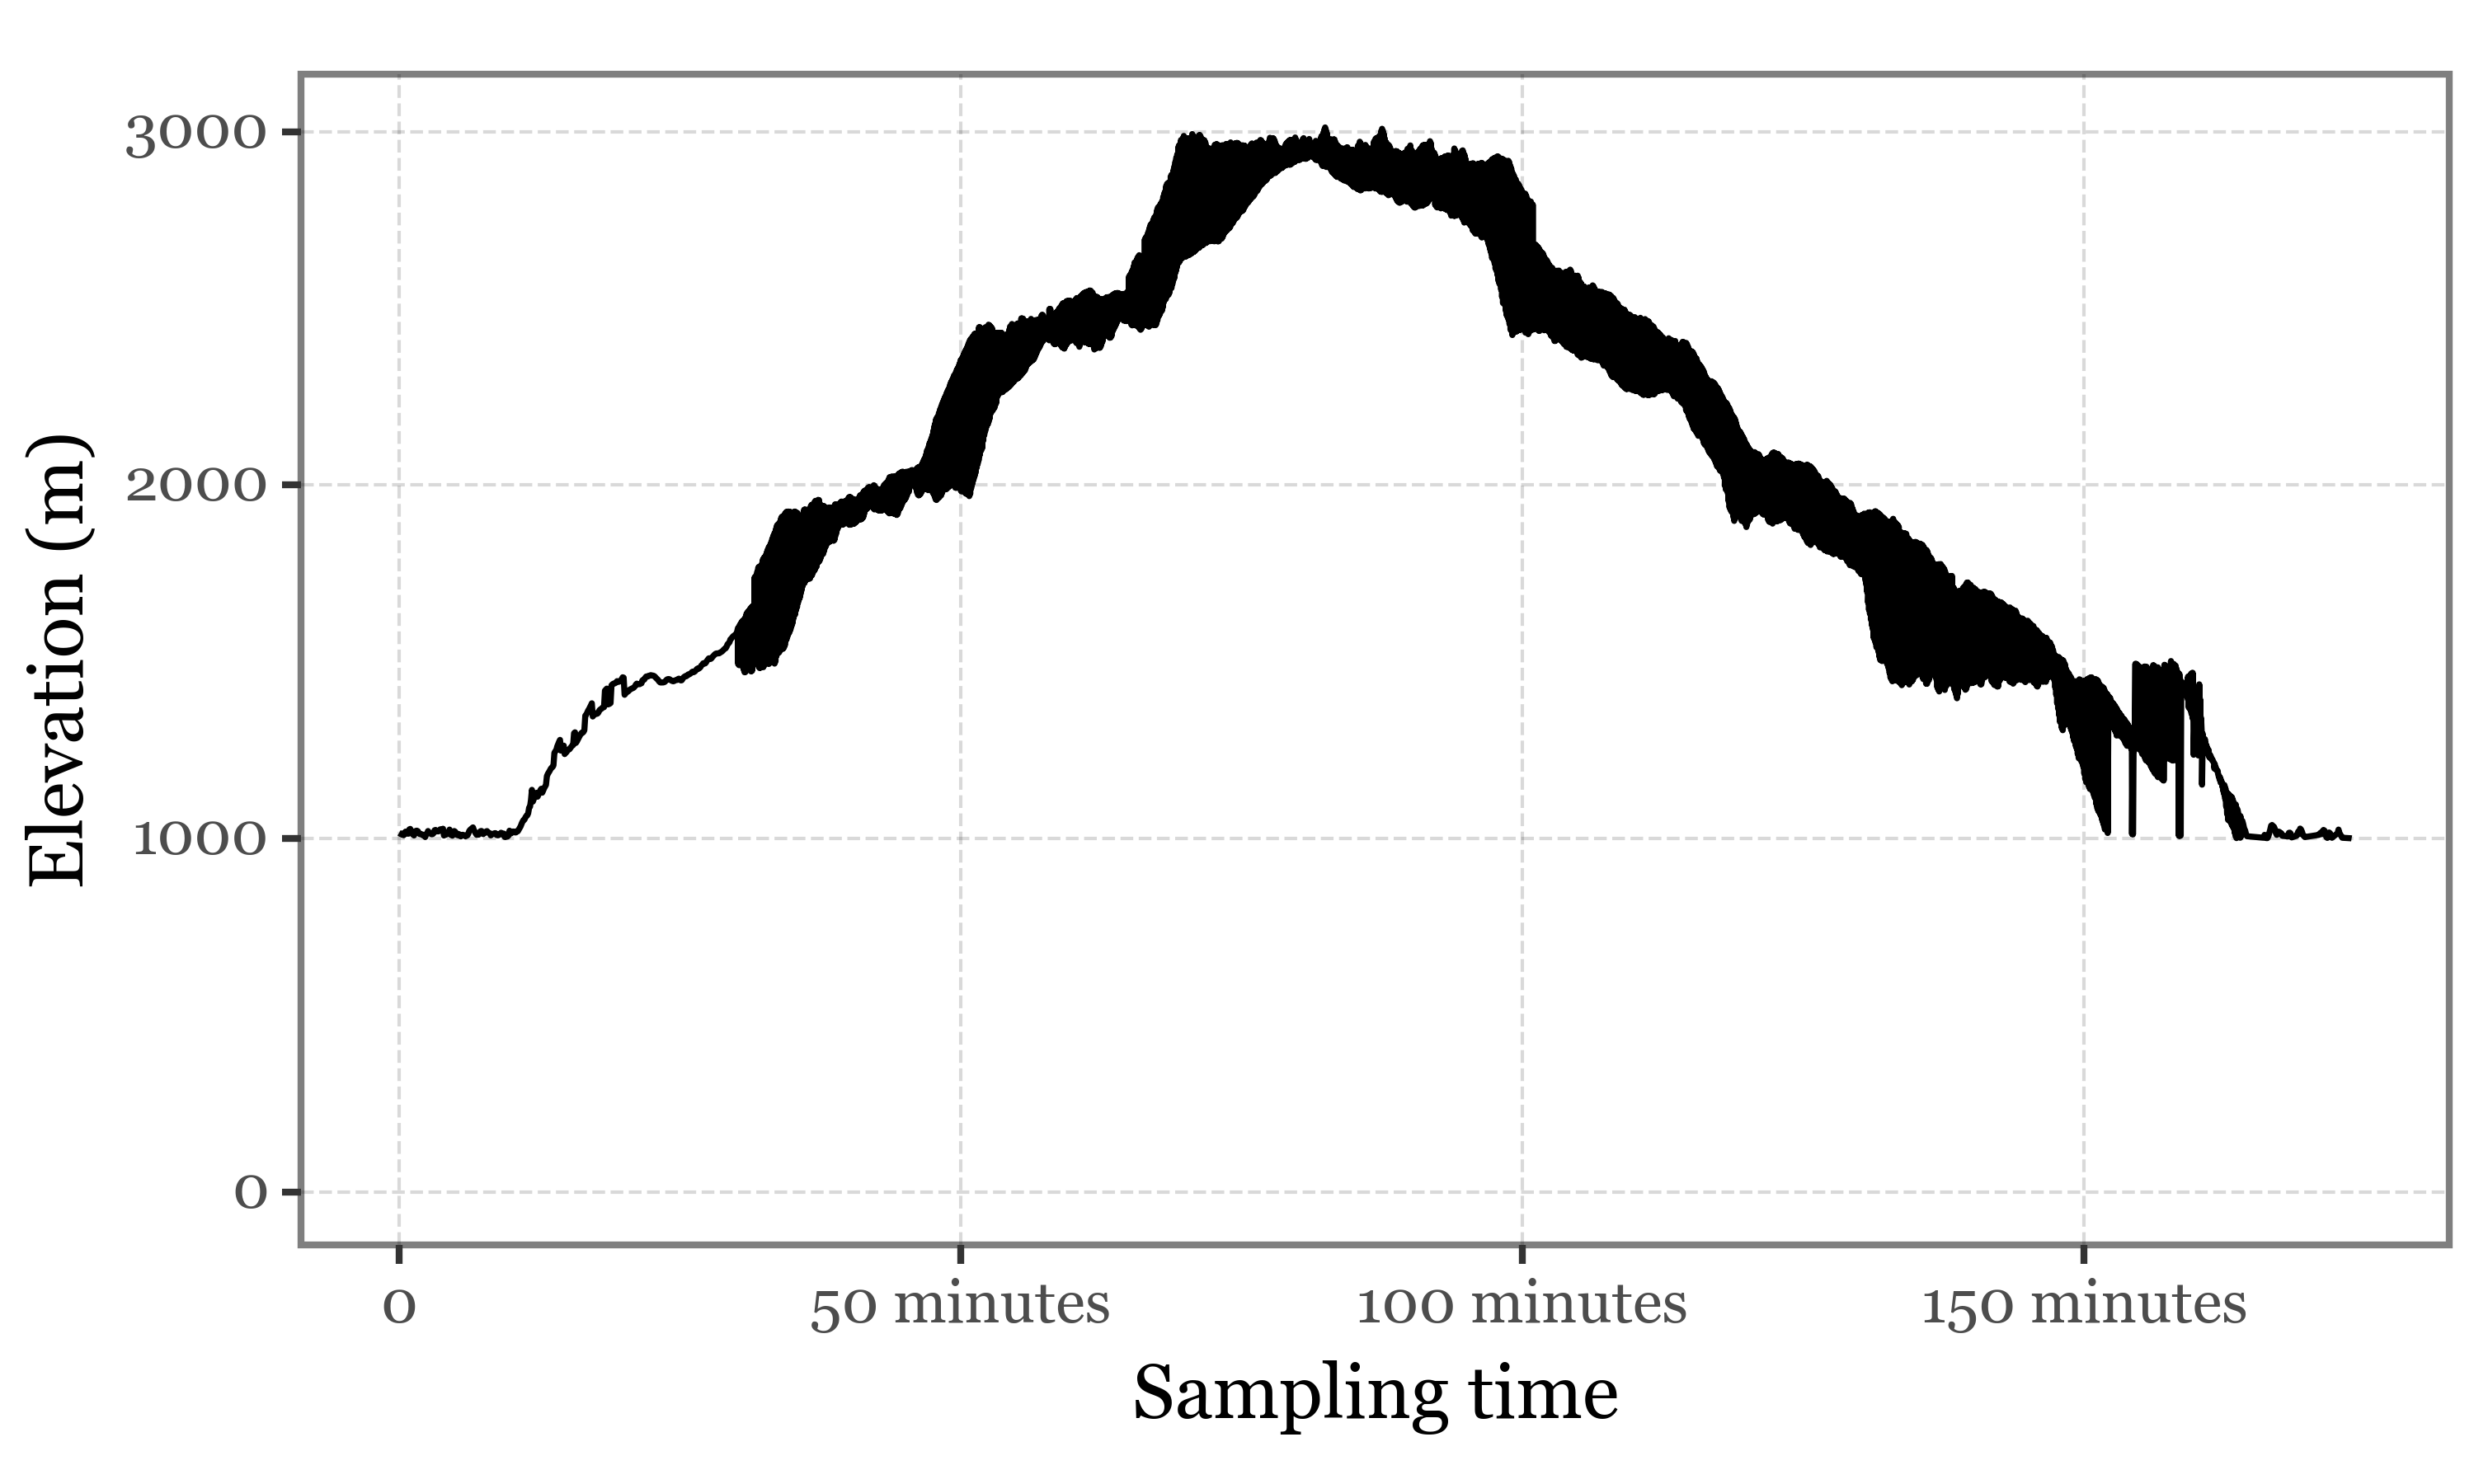

<Figure Size: (1500 x 900)>

In [18]:
(dfs
 .query('elevation >= 1000')
 .pipe(lambda dd: p9.ggplot(dd) 
    + p9.aes('timedelta', 'elevation', group='date')
    + p9.stat_summary(fun_y=np.mean, geom='line', group=1)
    + p9.theme(figure_size=(5, 3))
    + p9.scale_y_continuous(limits=(0, None))
    + p9.labs(x='Sampling time', y='Elevation (m)')
    )

)

In [83]:
(dfs
 .groupby('flight', as_index=False)
 .apply(lambda dd: dd.assign(timedelta=dd.time - dd.time.min()))
 .assign(flight=lambda dd: dd.flight.str.split('.').str[0].str[6:])
 .assign(time_since_last=lambda dd: dd.time.diff())
 .loc[lambda dd: dd['time_since_last'] < pd.to_timedelta("10 min")]
 .sort_values('time_since_last')
)

time   latitude   longitude  elevation  \
4 4 0    2014-02-22 04:23:10+00:00  35.705112  139.693024     992.70   
7 7 481  2014-02-24 03:44:29+00:00  36.378784  139.046143    1934.31   
1 1 803  2014-04-05 03:56:13+00:00  36.350403  138.807526    2614.44   
7 7 620  2014-02-24 03:56:03+00:00  36.285625  138.851639    2446.69   
8 8 380  2014-02-25 03:50:39+00:00  35.089394  139.429077    1738.68   
...                            ...        ...         ...        ...   
9 9 2023 2014-02-26 06:13:39+00:00  35.719494  139.641830     584.14   
3 3 362  2014-04-07 03:37:29+00:00  36.137989  139.313309    1494.51   
8 8 1189 2014-02-25 04:58:05+00:00  34.563652  139.066391    2512.06   
    1212 2014-02-25 05:00:01+00:00  34.608448  139.053665    2443.33   
6 6 0    2014-02-23 04:27:08+00:00  36.387970  138.302109    2888.90   

                    flight       timedelta    time_since_last  
4 4 0     22-FEB-14 055211 0 days 00:00:00 -45 days +22:24:36  
7 7 481   24-FEB-14 060218 0 days 00:40:04    0 days 00:00:04  
1 1 803   05-ABR-14 063542 0 days 01:06:52    0 days 00:00:04  
7 7 620   24-FEB-14 060218 0 days 00:51:38    0 days 00:00:04  
8 8 380   25-FEB-14 061343 0 days 00:31:39    0 days 00:00:04  
...                    ...             ...                ...  
9 9 2023  26-FEB-14 061335 0 days 02:48:35    0 days 00:00:05  
3 3 362   07-ABR-14 065833 0 days 00:30:11    0 days 00:00:06  
8 8 1189  25-FEB-14 061343 0 days 01:39:05    0 days 00:00:06  
    1212  25-FEB-14 061343 0 days 01:41:01    0 days 00:00:06  
6 6 0     23-FEB-14 055646 0 days 00:00:00    0 days 00:00:11  

[16474 rows x 7 columns]

In [101]:
from datetime import timedelta

datetime.timedelta(seconds=3600)

In [121]:
(dfs
  .assign(date=lambda dd: dd.time.dt.date)
  .sort_values('time')
  .timedelta.dt.total_seconds() / 60
)

4  0         0.000000
   1         0.083333
   2         0.166667
   3         0.250000
   4         0.333333
              ...    
3  2051    170.933333
   2052    171.016667
   2053    171.100000
   2054    171.183333
   2055    171.266667
Name: timedelta, Length: 16483, dtype: float64

In [131]:
dates = ['2014-02-22', '2014-02-23', '2014-02-24', '2014-02-25', '2014-02-26',
         '2014-04-01', '2014-04-05', '2014-04-06', '2014-04-07', '2014-04-08']

samples = ['S01', 'S03', 'S05', 'S07', 'S09', 'S13', 'S15', 'S17', 'S19', 'S21']

In [138]:
samples_df = pd.DataFrame(dict(date=dates, sample_id=samples)).assign(date=lambda dd: pd.to_datetime(dd.date))

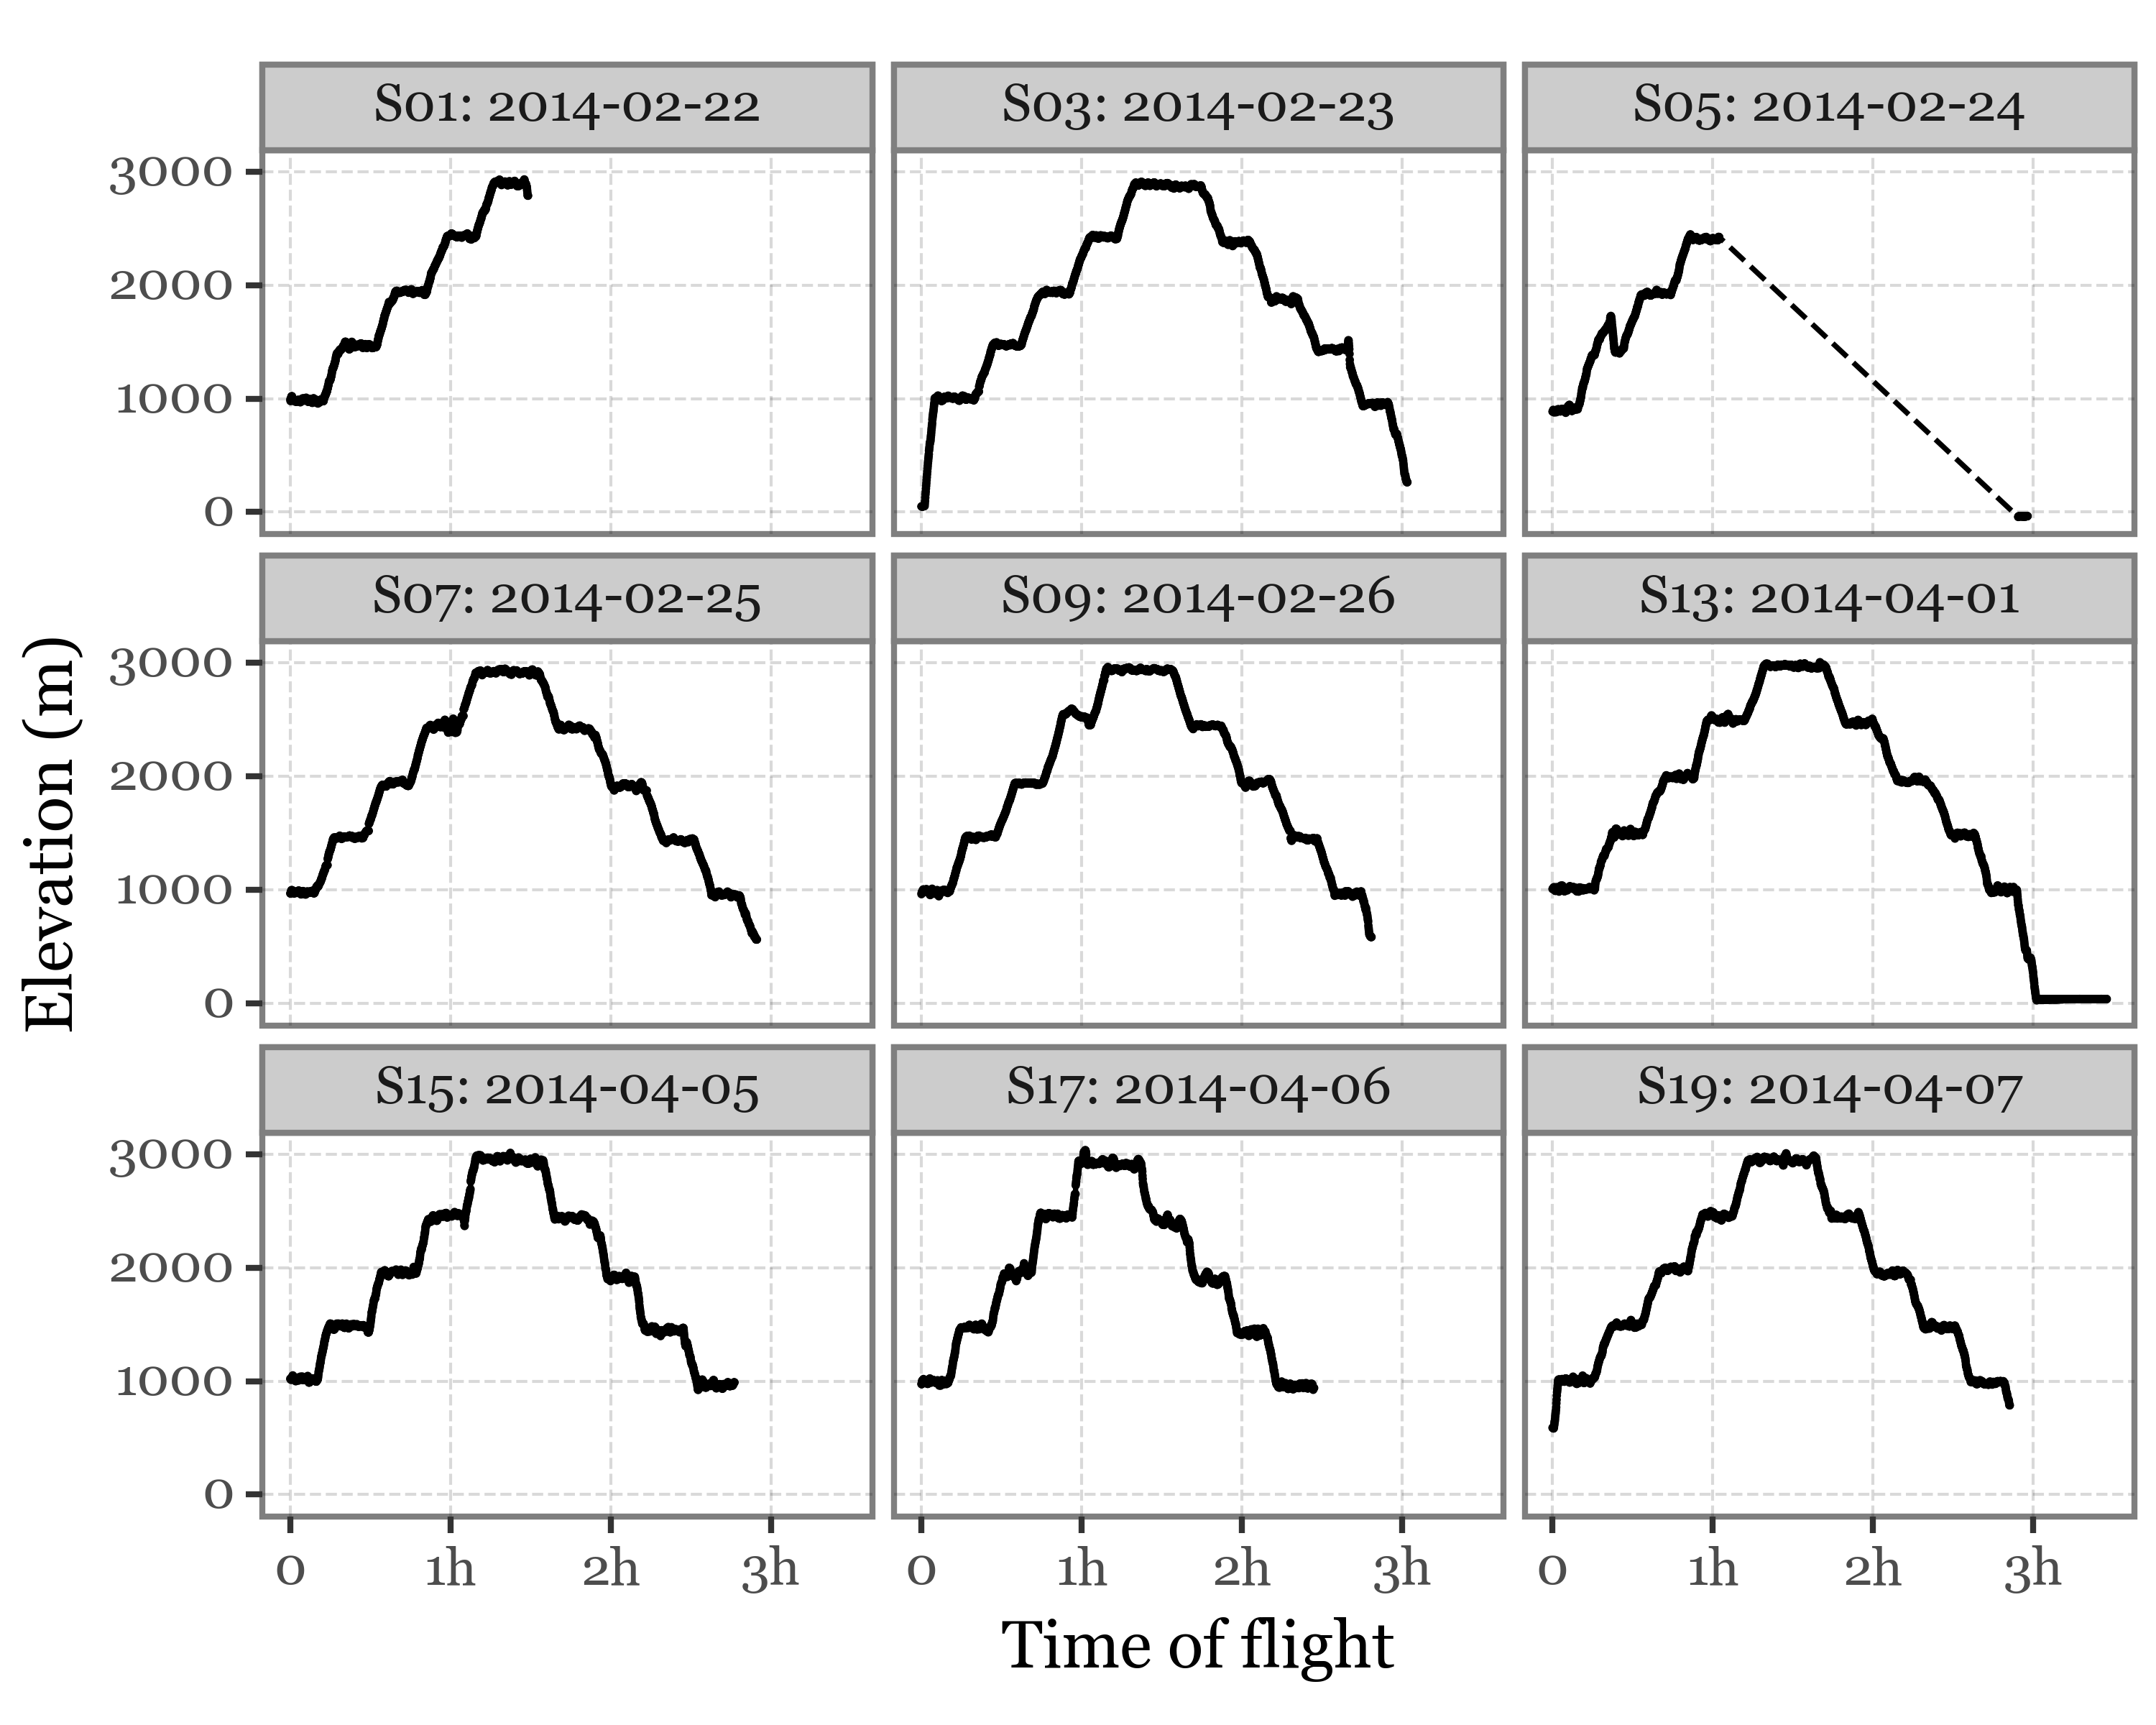

<Figure Size: (1500 x 1200)>

In [144]:
(dfs
  .assign(date=lambda dd: pd.to_datetime(dd.time.dt.date))
  .sort_values('time')
 .groupby('date', as_index=False)
 .apply(lambda dd: dd.assign(timedelta=(dd.time - dd.time.min()).dt.total_seconds() / 60)
         .assign(time_since_last=lambda dd: dd.timedelta.diff())
         .loc[lambda dd: dd['time_since_last'] < 10]
        )
 .assign(flight=lambda dd: dd.flight.str.split('.').str[0].str[6:])
 .merge(samples_df, on='date')
 .assign(label=lambda dd: dd.sample_id + ': ' + dd.date.astype(str))
 .pipe(lambda dd: p9.ggplot(dd) 
    + p9.aes('timedelta', 'elevation') 
    + p9.geom_line(p9.aes(group='flight'), linetype='dashed')
    + p9.scale_x_continuous(breaks=[0, 60, 120, 180], labels=['0', '1h', '2h', '3h'])
    + p9.geom_point(size=0, stroke=.4)
    + p9.labs(x='Time of flight', y='Elevation (m)')
    + p9.facet_wrap('label')
    + p9.theme(figure_size=(5, 4))
    )

 )

In [46]:
df.groupby('flight')

,time,latitude,longitude,elevation,flight
0,2014-02-23 04:27:08+00:00,36.387970,138.302109,2888.90,Track_23-FEB-14 055646.gpx
1,2014-02-23 04:27:13+00:00,36.389973,138.300217,2888.90,Track_23-FEB-14 055646.gpx
2,2014-02-23 04:27:18+00:00,36.392021,138.298401,2897.07,Track_23-FEB-14 055646.gpx
3,2014-02-23 04:27:23+00:00,36.393791,138.296173,2889.38,Track_23-FEB-14 055646.gpx
4,2014-02-23 04:27:28+00:00,36.395164,138.293594,2884.57,Track_23-FEB-14 055646.gpx
...,...,...,...,...,...
1072,2014-02-23 05:56:28+00:00,35.697174,139.566299,272.19,Track_23-FEB-14 055646.gpx
1073,2014-02-23 05:56:33+00:00,35.697247,139.563370,267.86,Track_23-FEB-14 055646.gpx
1074,2014-02-23 05:56:38+00:00,35.697376,139.560501,263.06,Track_23-FEB-14 055646.gpx
1075,2014-02-23 05:56:43+00:00,35.697498,139.557770,263.06,Track_23-FEB-14 055646.gpx


In [23]:
flight.tracks

[GPXTrack(name='Día 01-ABR-14 07:32:12', segments=[GPXTrackSegment(points=[...])])]

In [40]:
import os

['Day 07-APR-14 06.58.42.gpx',
 'Day 22-FEB-14 04.23.10.gpx',
 'Track_07-ABR-14 065833.gpx',
 'Day 05-APR-14 07.54.31.gpx',
 'Day 01-APR-14 07.32.12.gpx',
 'Track_23-FEB-14 042655.gpx',
 'Day 20-FEB-14 03.28.50.gpx',
 'Day 24-FEB-14 08.43.09.gpx',
 'Day 20-FEB-14 07.27.46.gpx',
 'Day 25-FEB-14 06.13.54.gpx',
 'Day 26-FEB-14 06.13.44.gpx',
 'Track_22-FEB-14 055211.gpx',
 'Track_24-FEB-14 060218.gpx',
 'Day 23-FEB-14 05.56.56.gpx',
 'Day 20-FEB-14 06.05.05.gpx',
 'Day 06-APR-14 05.14.06.gpx',
 'Day 08-APR-14 04.06.00.gpx',
 'Day 20-FEB-14 02.38.48.gpx',
 'Track_26-FEB-14 061335.gpx',
 'Track_06-ABR-14 051353.gpx',
 'Track_25-FEB-14 061343.gpx',
 'Track_05-ABR-14 063542.gpx',
 'Track_01-ABR-14 073152.gpx',
 'Track_23-FEB-14 055646.gpx']

In [26]:
df

,time,latitude,longitude,elevation
0,2014-02-20 07:27:46+00:00,35.669064,139.530518,52.05
1,2014-02-20 07:27:47+00:00,35.669064,139.530518,51.57
2,2014-02-20 07:27:48+00:00,35.669064,139.530518,51.57
3,2014-02-20 07:27:49+00:00,35.669064,139.530518,51.57
4,2014-02-20 07:27:50+00:00,35.669064,139.530518,51.57
...,...,...,...,...
8963,2014-02-20 19:38:23+00:00,35.650902,139.546219,47.72
8964,2014-02-20 19:38:24+00:00,35.650883,139.546219,47.72
8965,2014-02-20 19:38:25+00:00,35.650864,139.546219,47.72
8966,2014-02-20 19:38:26+00:00,35.650848,139.546219,47.72


In [10]:
world = gpd.read_file('../data/shapefiles/ne_50m_admin_0_countries.zip')

In [13]:
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,1,Zimbabwe,...,None,None,None,None,None,None,None,None,None,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,1,Zambia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,1,Yemen,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,1,Vietnam,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,1,Venezuela,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


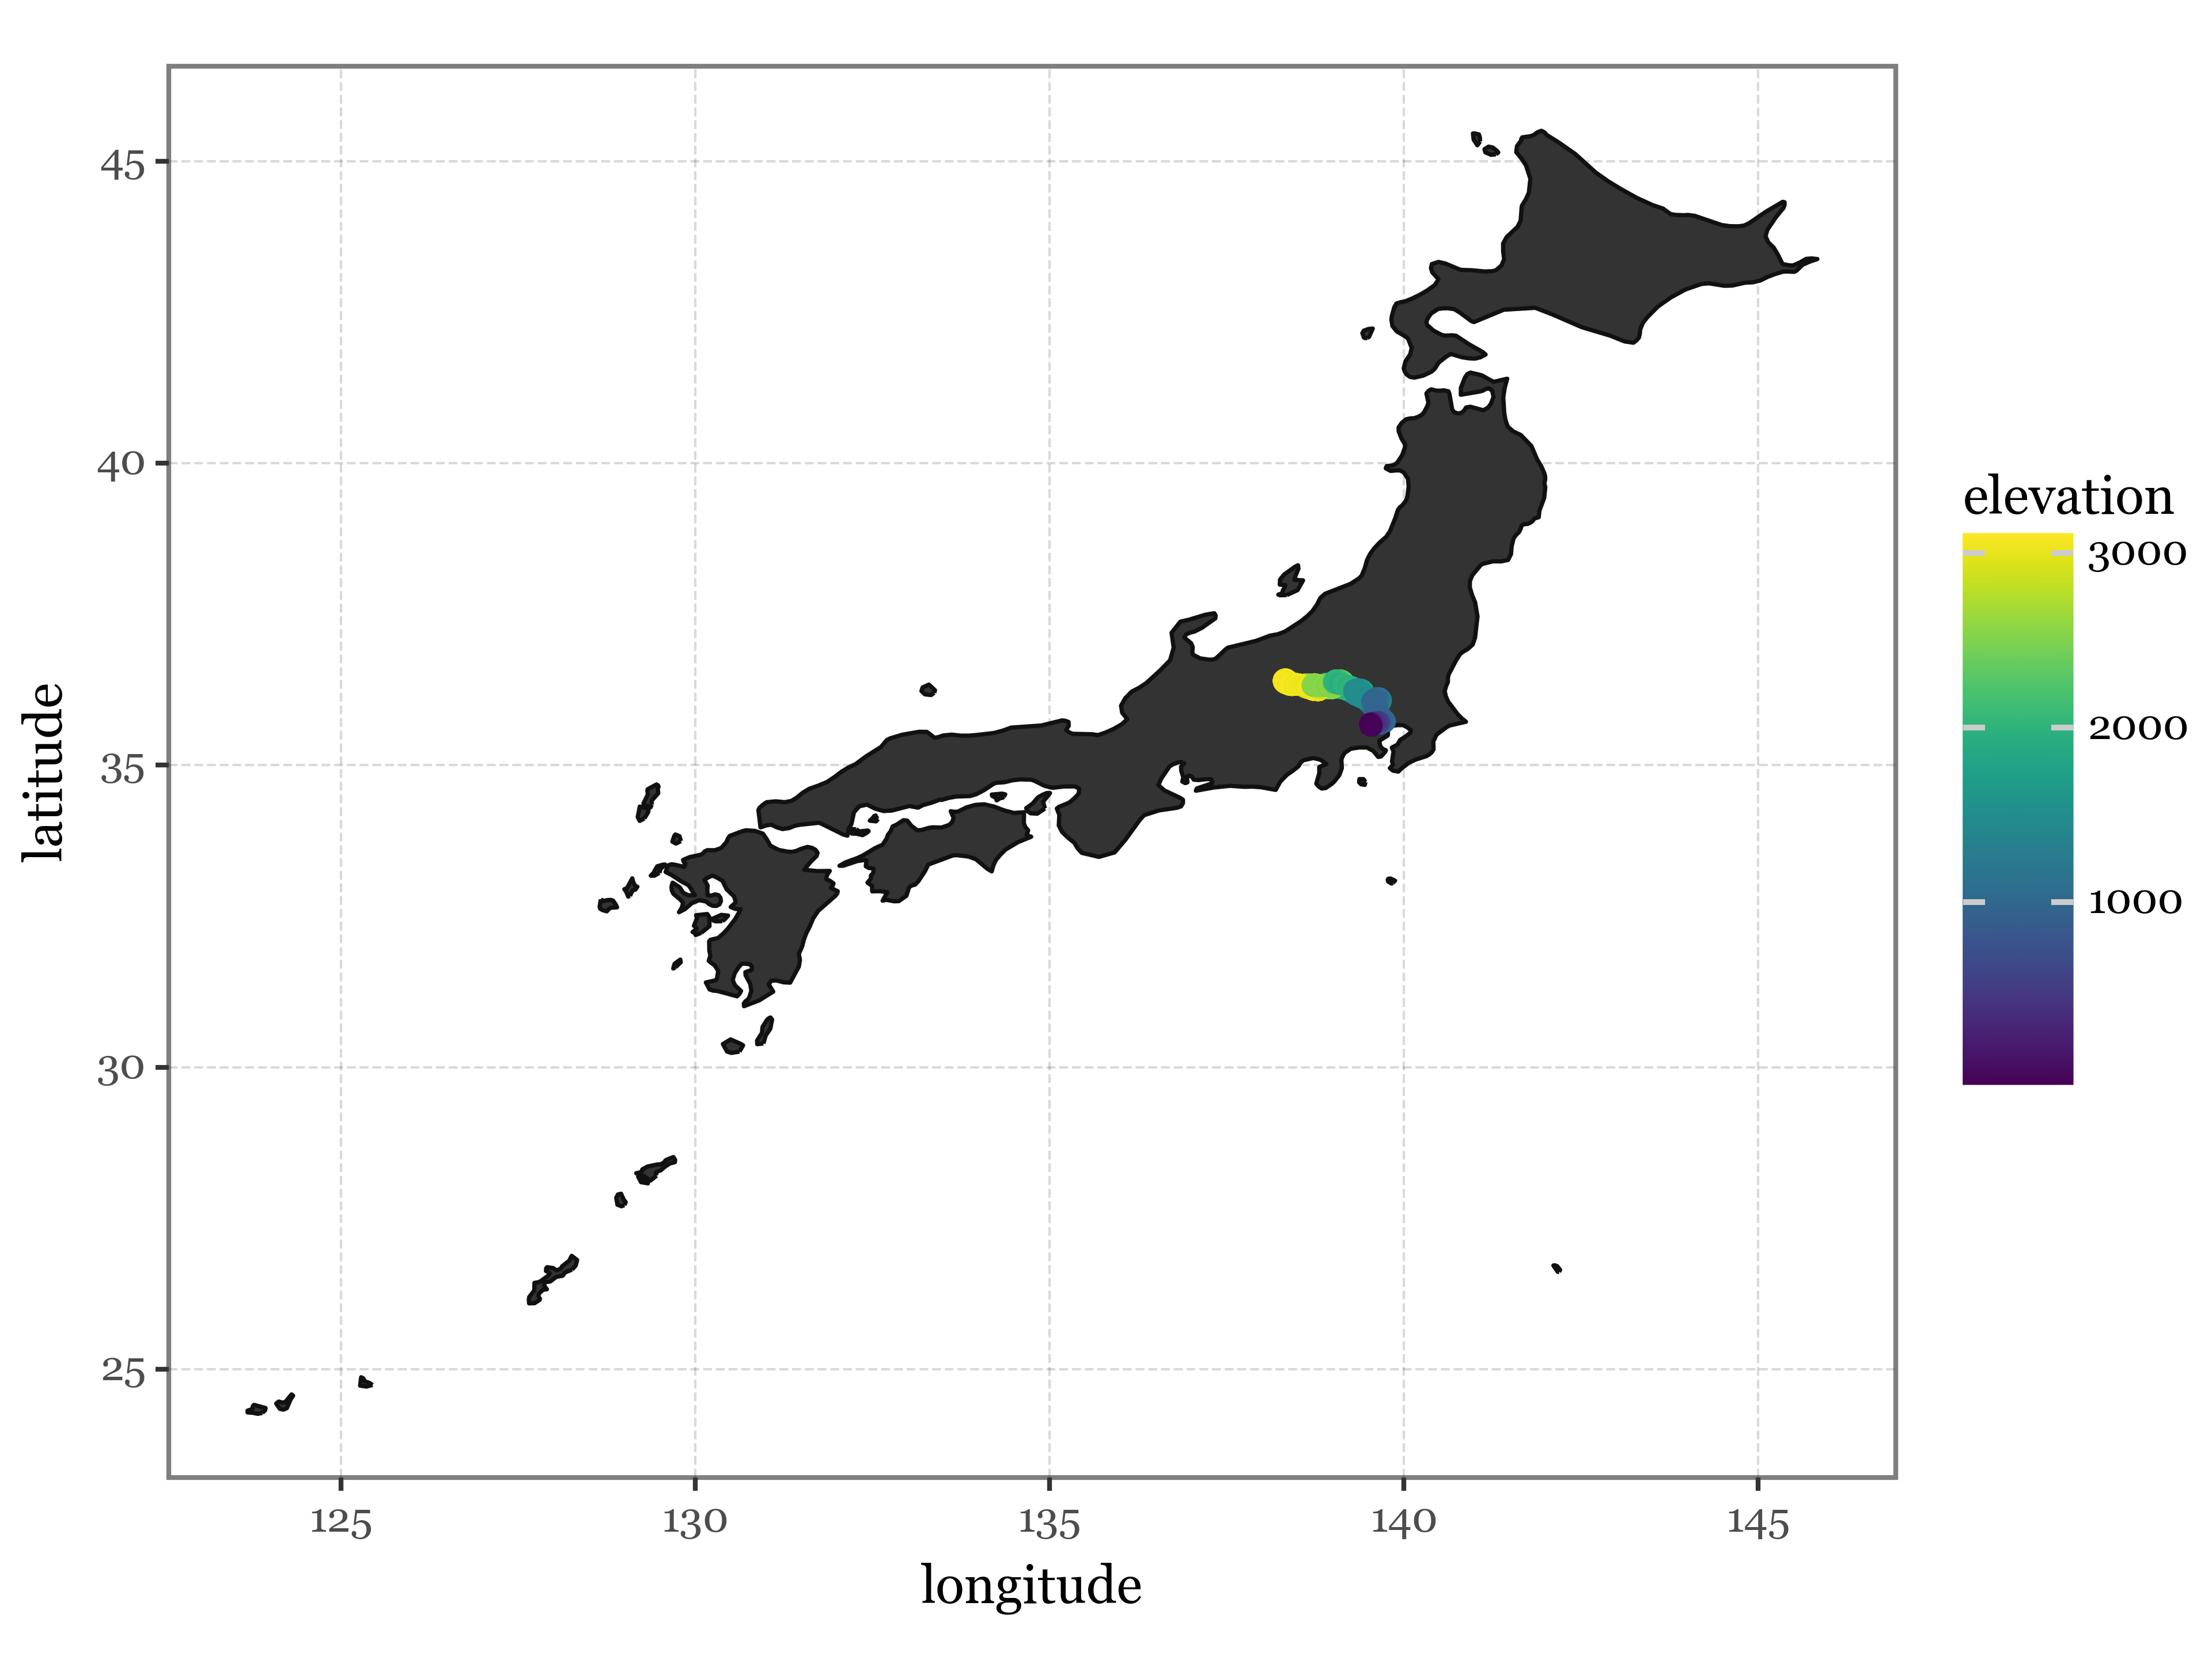

<Figure Size: (1920 x 1440)>

In [39]:
(p9.ggplot(world.query('SOV_A3=="JPN"'))
 + p9.geom_map()
 + p9.geom_point(p9.aes(x='longitude', y='latitude', color='elevation'), group=1, data=df)
 )

In [6]:
df

,time,latitude,longitude,elevation
0,2014-04-01 06:32:12+00:00,35.669037,139.530243,37.15
1,2014-04-01 06:32:17+00:00,35.669025,139.530289,37.63
2,2014-04-01 06:32:22+00:00,35.669022,139.530334,37.15
3,2014-04-01 06:32:27+00:00,35.669014,139.530396,37.15
4,2014-04-01 06:32:32+00:00,35.668999,139.530426,37.15
5,2014-04-01 06:32:37+00:00,35.668987,139.530472,37.15
6,2014-04-01 06:32:42+00:00,35.668976,139.530502,36.67
7,2014-04-01 06:32:47+00:00,35.668915,139.530487,37.15
8,2014-04-01 06:32:52+00:00,35.668903,139.530472,36.67
9,2014-04-01 06:32:57+00:00,35.668896,139.530426,36.67
